# Dataset and Dataloaders

在机器学习中处理与读取数据是一件非常麻烦的事情，Pytorch对数据的读取做了统一的抽象，Pytorch中提供了2个基本的数据原语：`torch.utils.data.DataLoader`以及`torch.utils.data.Dataset`。

Dataset中保存着我们的数据样本以及它们对应的标签，而Dataloader是在Dataset外面做了一个包装，把它包装成一个可迭代的对象，方便我们访问Dataset中的样本。

另外Pytorch中还提供了一些派生于`torch.utils.data.Dataset`的用于加载公开测试集的类。

我们可以用这些数据集来做为我们模型的benchmark测试。

- [Image Datasets](https://pytorch.org/vision/stable/datasets.html)
- [Text Datasets](https://pytorch.org/text/stable/datasets.html)
- [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

# Dataset

Dataset负责对raw data source（Tensor、本地图片目录、csv数据、KV数据库等）进行封装，将其封装为Pytorch可识别的数据结构。它必须提供提取数据个体的接口`__getitem()__`。

Dataset共有Map-style dataset和Iterable-style dataset。

- map-style dataset：实现了`__getitem__`和`__len__`接口，表示一个从索引key到样本数据的map，比如：`dataset[10]`就表示第10个样本。
- iterable-style dataset: 实现了`__iter__`接口，表示在data sampls上的一个可迭代的对象，这种形式的dataset非常不适合随机存取（代价太高），但非常适合处理流式数据。对于这样的数据集，我们可以通过`iter(dataset)`获取迭代器，然后不断使用`next`迭代，实现遍历。

所以说`Dataset`是可迭代对象，可以用`for xx in ds`这样的语法，但是不是迭代器，不可以直接通过`next`来获取元素。

torch.utils.data.Dataset是一个抽象类，所有Map-Style的Dataset相关的类都应该继承它。这些子类必须要实现`__getitem__`和`__len__`。

pytorch中提供了一个TensorDataset就是Dataset的一个子类。我们可以通过这个实现来看到如何写一个dataset的子类。

```python
class TensorDataset(Dataset[Tuple[Tensor, ...]]):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """
    tensors: Tuple[Tensor, ...]

    # 构造函数传入的是多个Tensor，但要求多个Tensor在第一维上长度要相同
    def __init__(self, *tensors: Tensor) -> None:
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
    # 按index为key取出每个Tensor的元素，拼成一个tuple返回
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)
```

torch.utils.data.IterableDataset是另外一个抽象基类，所有iterable-style的Dataset都需要继承该类。所以继续这个类的子类，都需要实现`__iter__`方法。

# 读取公开测试集FashionMNIST的示例

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from d2l import d2l

In [2]:
training_set = datasets.FashionMNIST(
    root="../data", train=True, download=True, transform=ToTensor()
)

In [3]:
testing_set = datasets.FashionMNIST(
    root="../data", train=False, download=True, transform=ToTensor()
)

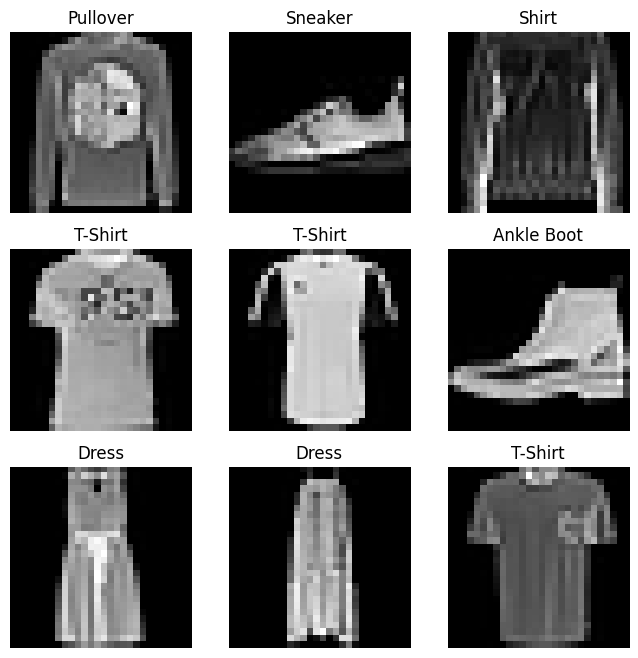

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    # 通过索引直接访问数据集
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(labels_map[label])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    # img.shape: (1, 28, 28)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Sampler

Sampler负责提供一种遍历数据集所有元素索引的方式：比如随机，顺序，按某种分布生成等。

Sampler的所有子类都要实现`__iter__`用来提供遍历dataset索引的方式。我们获得不同的索引遍历，就是以不同的方式遍历dataset，这就是sampler的目的。

sampler每迭代一次，返回的都是Dataset的key。

Pytorch为我们提供了几种现成的Sampler子类：

- SequentialSampler
- RandomSampler
- SubsetRandomSampler
- WeightedRandomSampler
- BatchSampler
- DistributedSampler

Sampler的难点在于，在多进程的情况下，每个worker要根据worker id返回其对应的索引。

# Dataloader

有了Dataset后，其实我们已经可以通过下标下访问数据集中的每个样本了，但实际我们在做深度学习时，我们可能还有下面的需求：

- 希望按一个minbatch来读取数据
- 在每个epoch对整个数据集进行一次shuffle读取
- 可以使用多线程来加速读取与预处理数据

`Dataloader`就可以帮助dataset我们做这样的事情

Dataloader负责加载数据，同时支持map-style dataset和iterable-style dataset，支持单进程/多进程。同时还可以设置loading order、batch size、pined memory等。

```python
Dataloader(dataset, batch_size, shuffle, num_worker,collate_fn,drop_last) -> Dataloader()
```
我们通过传入dataset和一些参数返回一个`Dataloader`,它是一个可迭代的对象

In [5]:
training_dataloader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True, num_workers=2
)

In [6]:
batch_samples, labels = next(iter(training_dataloader))
print(f"batch samples shape: {batch_samples.shape}")
print(labels)

batch samples shape: torch.Size([4, 1, 28, 28])
tensor([1, 1, 6, 9])


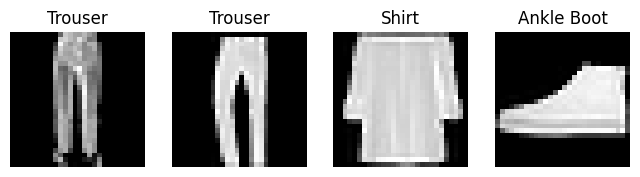

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 1
for i in range(cols * rows):
    img = batch_samples[i]
    label = labels[i].item()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# DataLoader的背后原理

DataLoader是一个可迭代对象，所以它的核心功能就是内部的`__iter__`方法，如何返回Dataset中的一个样本。

所以它先要获取一个或一批索引（dataset的key），它是由创建Dataloader时的Sampler提供的，Sampler也是一个可迭代法对象，返回key值。

然后就是根据index来到Dataset里取数据，但是因为dataset有两类：map-style和iterable-style，所以直接用index不容易同时操作这两种对象。

pytorch又在访问两种style dataset之上，抽象了一个dataset_fetcher抽象类，它实现了一个fetch接口。对应的子类有：`_IterableDatasetFetcher`和`_MapDatasetFetcher`。

# 从头实现一个自定义的图片分类测试集

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

## 数据集介绍

数据集是一个关于花的分类的数据集，它一共有5类，分别是:

- daisy 雏菊 633个样本
- dandelion 蒲公英 898个样本
- roses 玫瑰 641个样本
- sunflowers 向日葵 699个样本
- tulips 郁金香 799个样本

数据集放在data/flower_photos目录下，每一类花就是一个文件夹，文件夹的名字是花的种类。

In [5]:
data_root = "../data/flower_photos"
flower_kinds = [
    kind
    for kind in os.listdir(data_root)
    if os.path.isdir(os.path.join(data_root, kind))
]
flower_kinds.sort()
kind_indices = {kind: i for i, kind in enumerate(flower_kinds)}
print(kind_indices)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## 读取所有图片路径，并划分训练集与验证集

In [49]:
validation_rate = 0.2
training_images = []
training_labels = []
validation_images = []
validation_labels = []
kind_total = []
support_images = [".jpg", ".jpeg", ".png", ".bmp"]
for flower, label in kind_indices.items():
    flower_folder = os.path.join(data_root, flower)
    images = [
        os.path.join(flower_folder, image)
        for image in os.listdir(flower_folder)
        if os.path.isfile(os.path.join(flower_folder, image))
        and os.path.splitext(image)[-1] in support_images
    ]
    num_samples = len(images)
    kind_total.append(num_samples)
    num_train = int(num_samples * (1 - validation_rate))
    sampling_index = np.arange(num_samples)
    np.random.shuffle(sampling_index)
    training_images += [images[i] for i in sampling_index[:num_train]]
    training_labels += (np.ones(num_train, dtype="int64") * label).tolist()
    validation_images += [images[i] for i in sampling_index[num_train:]]
    validation_labels += (
        np.ones(num_samples - num_train, dtype="int64") * label
    ).tolist()

统计每个类别样本的数量

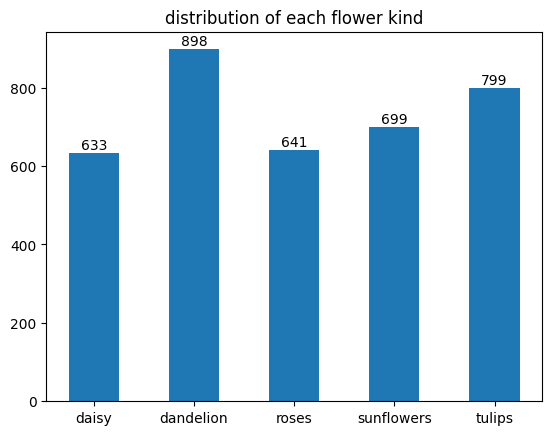

In [7]:
plt.title("distribution of each flower kind")
plt.bar(range(len(kind_total)), kind_total, width=0.5, tick_label=flower_kinds)
for i, v in enumerate(kind_total):
    plt.text(x=i, y=v + 10, s=str(v), ha="center")

## 创建自定义数据集FlowerDataset

In [51]:
from torch.utils.data import Dataset
from PIL import Image


class FlowerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image)) / 255.0
        return image, torch.tensor(self.labels[index], dtype=torch.int64)

    def __len__(self):
        return len(self.images)

    # 由于每张图片的大小不同，所以没办法直接使用default_collate_fn（会调用stack）
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        # 返回的images和labels都是一个tuple的形式
        return torch.stack(images, dim=0), torch.stack(labels, dim=0)

In [52]:
training_data = FlowerDataset(training_images, training_labels)

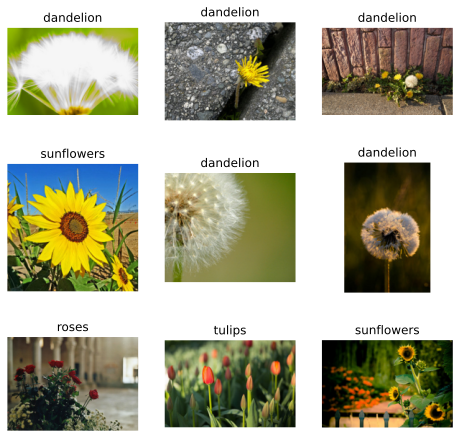

In [53]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_images), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[int(label.item())])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(img.numpy())
plt.show()

In [60]:
import torchvision.transforms as trans

transform = trans.Compose(
    [
        trans.RandomResizedCrop((224, 224)),
        trans.ToTensor(),  # PIL image (HWC,0-255) -> Tensor(CHW, 0-1)
    ]
)

training_data = FlowerDataset(training_images, training_labels, transform)

training_dataloader = torch.utils.data.DataLoader(
    training_data, batch_size=4, shuffle=True, collate_fn=training_data.collate_fn
)

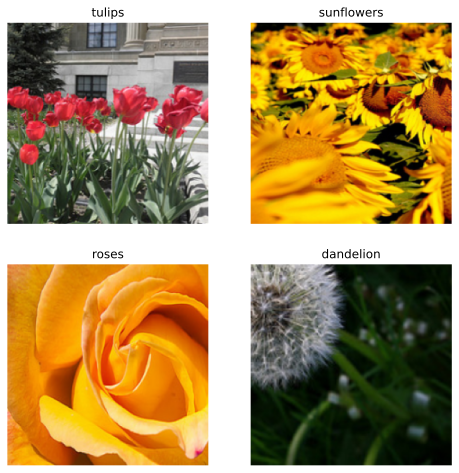

In [63]:
batch_samples, labels = next(iter(training_dataloader))
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[int(labels[i].item())])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(batch_samples[i].numpy().transpose((1, 2, 0)))
plt.show()

## 带Transform的dataset

In [13]:
import torchvision.transforms as trans

In [28]:
transform = trans.Compose(
    [
        trans.RandomResizedCrop((224, 224)),
        trans.ToTensor(),  # PIL image (HWC,0-255) -> Tensor(CHW, 0-1)
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [15]:
img = Image.open(training_images[0])
img = transform(img)
print(f"trasnformed image: {img.shape}")

trasnformed image: torch.Size([3, 224, 224])


In [16]:
training_data_with_trasform = FlowerDataset(training_images, training_labels, transform)

In [17]:
first_sample, label = training_data_with_trasform[0]
print(f"tensor shape: {first_sample.shape}, lable = {label}")

tensor shape: torch.Size([3, 224, 224]), lable = 0.0


In [18]:
# 由于dataset经过transform后，所有图片都是一样的大小，这时候，我们可以不用再提供collect_fn
training_dataloader = torch.utils.data.DataLoader(
    training_data_with_trasform, batch_size=4, shuffle=True
)
batch_samples, labels = next(iter(training_dataloader))
print(f"batch_samples.type: {type(batch_samples)}")

batch_samples.type: <class 'torch.Tensor'>


# 使用 ImageFolder

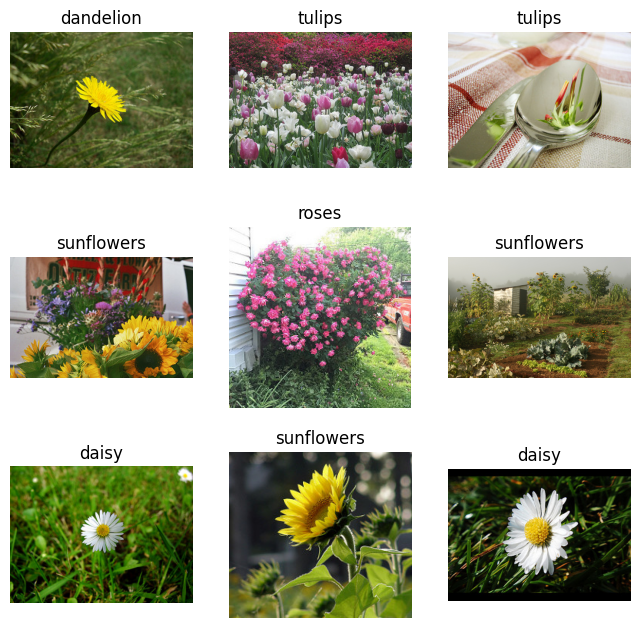

In [19]:
import torchvision.datasets

flower_dataset = torchvision.datasets.ImageFolder("../data/flower_photos/")

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_images), size=(1,)).item()
    # img (PIL image), label (int)
    img, label = flower_dataset[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[label])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(img)
plt.show()

# 带权重的样本采样器

当我们的数据集存在类别不均衡的问题时，我们可以采用带权重的Sampler来对数量较少的类别进行重复采样。

In [8]:
import torchvision.datasets
import os

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

data_root = "../data/flower_photos/"
flower_dataset = torchvision.datasets.ImageFolder(data_root, transform=transform)

subdirectories = flower_dataset.classes
class_weights = []
for subdir in subdirectories:
    files = os.listdir(os.path.join(data_root, subdir))
    class_weights.append(1 / len(files))

sample_weights = [0] * len(flower_dataset)

# 每个样本采样的权重为 1 / sampels，样本数量越少，则权重越大
for idx, (data, label) in enumerate(flower_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)
loader = torch.utils.data.DataLoader(flower_dataset, batch_size = 8, sampler=sampler)

对整个数据集采用5次，然后统计的样本中每一个类别采样到的数量

In [7]:
num_retrivevers = [0] * len(flower_dataset.classes)

for epoch in range(5):
    for data, labels in loader:
        for id in range(len(num_retrivevers)):
            num_retrivevers[id] += torch.sum(labels == id).item()

print(num_retrivevers)


[3784, 3683, 3670, 3578, 3635]
